# Multi Layer Perceptron

Multilayer Perceptrons (MLPs) are a type of neural network architecture composed of fully connected layers. They are widely used for classification and regression tasks. Each neuron in an MLP takes input, applies a weight and bias, passes it through an activation function, and outputs a value to the next layer. For image classification, MLPs require input images to be flattened into vectors, making them less effective on raw image data compared to Convolutional Neural Networks (CNNs). However, with smaller datasets or simpler tasks, MLPs can still achieve good results.

### Installing libraries

In [1]:
!pip install tensorflow numpy matplotlib scikit-learn
!pip install imbalanced-learn

### Loading and Preprocessing Data

In [2]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths
dataset_path = "C:/Users/moham/Desktop/Data Mining and ML/Processed Leaf Images"

# Parameters
image_size = (64, 64)  # Resize images to 64x64

### Normalizing data

In [3]:
data = []
labels = []
class_names = os.listdir(dataset_path)

for label, folder in enumerate(class_names):
    folder_path = os.path.join(dataset_path, folder)
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        image = load_img(image_path, target_size=image_size)
        image_array = img_to_array(image)   # Image as numpy array
        data.append(image_array)
        labels.append(label)

data = np.array(data)
labels = np.array(labels)

# Normalize the data
data = data / 255.0  # Normalize images to [0, 1] range

### Data balancing and augmentation using SMOTE

In [4]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Flatten the image data for SMOTE
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Reshape to [n_samples, n_features]

# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled_flat, y_resampled = smote.fit_resample(X_train_flat, y_train)

# Reshape the resampled data back to the original image shape
X_resampled = X_resampled_flat.reshape(X_resampled_flat.shape[0], 64, 64, 3)

# One-hot encode the labels
y_resampled = to_categorical(y_resampled, num_classes=len(class_names))

# One-hot encode the test labels
y_test = to_categorical(y_test, num_classes=len(class_names))

# Augment the SMOTE-resampled training data (optional)
train_datagen = ImageDataGenerator(
    rotation_range=40,  # Random rotation of up to 40 degrees
    width_shift_range=0.2,  # Random horizontal shifts
    height_shift_range=0.2,  # Random vertical shifts
    shear_range=0.2,  # Random shearing
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest'  # Fill in missing pixels after transformations
)

# The test data should not be augmented, just normalized
test_datagen = ImageDataGenerator()

# Create data generators
train_generator = train_datagen.flow(X_resampled, y_resampled, batch_size=32)
validation_generator = test_datagen.flow(X_test, y_test, batch_size=32)


### Building the MLP model

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

# Build the model
model = Sequential([
    Flatten(input_shape=(64, 64, 3)),  # Flatten 64x64x3 image into a vector
    Dense(128, activation='relu'),    # First hidden layer with 128 neurons
    Dense(64, activation='relu'),     # Second hidden layer with 64 neurons
    Dense(len(class_names), activation='softmax')  # Output layer for classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

C:\Users\moham\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 12288)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,572,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,581,573 (6.03 MB)

 Trainable params: 1,581,573 (6.03 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model over 10 epochs

In [6]:
# Train the model with augmented data
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10


C:\Users\moham\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2384/2384 ━━━━━━━━━━━━━━━━━━━━ 91s 38ms/step - accuracy: 0.5719 - loss: 1.0544 - val_accuracy: 0.8500 - val_loss: 0.3966
Epoch 2/10
2384/2384 ━━━━━━━━━━━━━━━━━━━━ 88s 37ms/step - accuracy: 0.7710 - loss: 0.5680 - val_accuracy: 0.9299 - val_loss: 0.2083
Epoch 3/10
2384/2384 ━━━━━━━━━━━━━━━━━━━━ 89s 37ms/step - accuracy: 0.8344 - loss: 0.4210 - val_accuracy: 0.9009 - val_loss: 0.2597
Epoch 4/10
2384/2384 ━━━━━━━━━━━━━━━━━━━━ 89s 37ms/step - accuracy: 0.8732 - loss: 0.3392 - val_accuracy: 0.9371 - val_loss: 0.1684
Epoch 5/10
2384/2384 ━━━━━━━━━━━━━━━━━━━━ 88s 37ms/step - accuracy: 0.8874 - loss: 0.3029 - val_accuracy: 0.9616 - val_loss: 0.1261
Epoch 6/10
2384/2384 ━━━━━━━━━━━━━━━━━━━━ 88s 37ms/step - accuracy: 0.8971 - loss: 0.2808 - val_accuracy: 0.9680 - val_loss: 0.1020
Epoch 7/10
2384/2384 ━━━━━━━━━━━━━━━━━━━━ 88s 37ms/step - accuracy: 0.9059 - loss: 0.2566 - val_accuracy: 0.9699 - val_loss: 0.0868
Epoch 8/10
2384/2384 ━━━━━━━━━━━━━━━━━━━━ 88s 37ms/step - accuracy: 0.9119 - loss: 0.24

### Metrics

In [7]:
# Evaluate on the test set (no augmentation on test set)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9745 - loss: 0.0777
Test Accuracy: 97.28%


366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


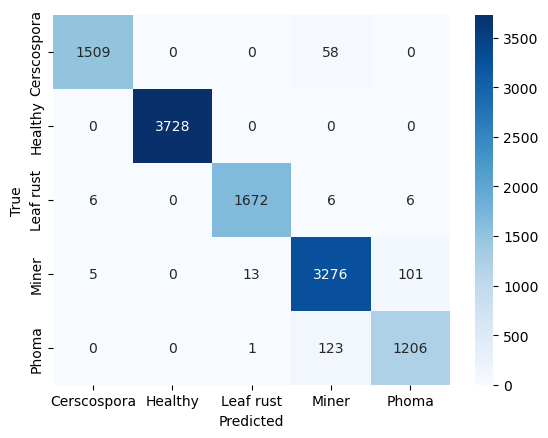

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Precision, recall, F1 for each class
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)

# Print metrics for each class
for i, class_name in enumerate(class_names):
    print(f"{class_name}: Precision={precision[i]:.2f}, Recall={recall[i]:.2f}, F1-Score={f1[i]:.2f}")


Cerscospora: Precision=0.99, Recall=0.96, F1-Score=0.98
Healthy: Precision=1.00, Recall=1.00, F1-Score=1.00
Leaf rust: Precision=0.99, Recall=0.99, F1-Score=0.99
Miner: Precision=0.95, Recall=0.96, F1-Score=0.96
Phoma: Precision=0.92, Recall=0.91, F1-Score=0.91
